<a href="https://colab.research.google.com/github/ethanrom/ResNET50-helmet-no_helmet/blob/main/pytorch_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


dataset modified in roboflow 6.4K images

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="zTxvKFTggq8hIQ8Ss6Bw")
project = rf.workspace("ku-iwzzj").project("helmet_no_helmet-7s0uu")
dataset = project.version(1).download("folder")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 385 kB/s 
     |████████████████████████████████| 145 kB 52.0 MB/s 
     |████████████████████████████████| 138 kB 53.4 MB/s 
     |████████████████████████████████| 67 kB 6.6 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 178 kB 68.5 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=972b2dd9f1bebbc2ba9ce305ae89b121cd881ada82d0eed15cf5f2dd6e56b803
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: certifi
    Found existing installation: certi

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to helmet_no_helmet-1 in folder:: 100%|██████████| 6971/6971 [00:06<00:00, 1159.78it/s]


original dataset
<p>2600 samples for training
155 for validation</p>
<p>Gathered using keyword search</p>

In [ ]:
!cp -r /content/gdrive/MyDrive/datasets/data .

importing dependencies

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

pytorch data generators

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder('data/train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder('data/validation', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True, num_workers=4),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False, num_workers=4)
}

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


creating neural net

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

Model training

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss.item(),
                                                        epoch_acc.item()))
    return model

In [ ]:
model_trained = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------
train loss: 0.0635, acc: 0.9787
validation loss: 0.0535, acc: 0.9869
Epoch 2/10
----------
train loss: 0.0257, acc: 0.9916
validation loss: 0.0082, acc: 0.9981
Epoch 3/10
----------
train loss: 0.0361, acc: 0.9868
validation loss: 0.0343, acc: 0.9906
Epoch 4/10
----------
train loss: 0.0177, acc: 0.9938
validation loss: 0.0217, acc: 0.9944
Epoch 5/10
----------
train loss: 0.0217, acc: 0.9913
validation loss: 0.0151, acc: 0.9944
Epoch 6/10
----------
train loss: 0.0161, acc: 0.9927
validation loss: 0.0238, acc: 0.9925
Epoch 7/10
----------
train loss: 0.0207, acc: 0.9933
validation loss: 0.0174, acc: 0.9925
Epoch 8/10
----------
train loss: 0.0302, acc: 0.9886
validation loss: 0.0578, acc: 0.9850
Epoch 9/10
----------
train loss: 0.0132, acc: 0.9958
validation loss: 0.0203, acc: 0.9925
Epoch 10/10
----------
train loss: 0.0081, acc: 0.9967
validation loss: 0.0484, acc: 0.9888


save & load

In [ ]:
torch.save(model_trained.state_dict(), 'weights.h5')

In [ ]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('weights.h5'))

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.


<All keys matched successfully>

testing

In [ ]:
validation_img_paths = ["ixmagesqtbnANd9GcTTohc8reXkWm0bLUbt4fyFzEiHDnzbMsg7gusqpCAU.jpg",
                        "x1.jpg",
                        "augmented_image_260.jpg",
                        "x2.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [ ]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [ ]:
pred_logits_tensor = model(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

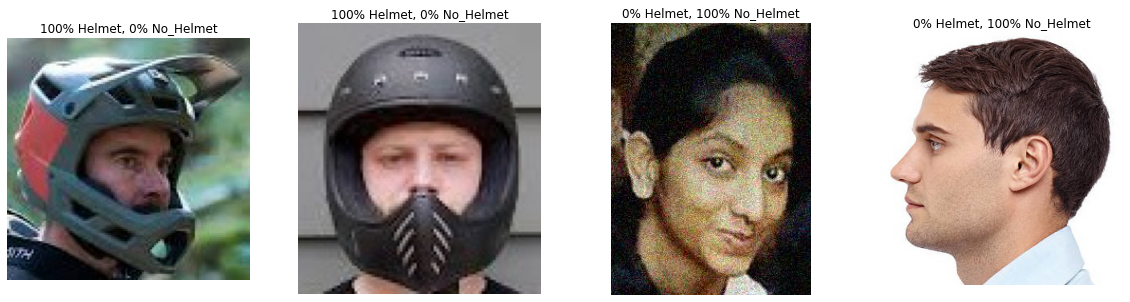

In [ ]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Helmet, {:.0f}% No_Helmet".format(100*pred_probs[i,0],
                                                          100*pred_probs[i,1]))
    ax.imshow(img)

save model to drive

In [ ]:
!cp weights.h5 /content/gdrive/MyDrive/

for quick testing

In [ ]:
!gdown 1QIxzI8S1Vr_vFL3OhpEiUwv2dxMVwAy7